In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from IPython import display

import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader


np.random.seed(11)

IN_SIZE = 2
num_neuro_1 = 15
num_neuro_2 = 15
num_neuro_3 = 10

RES_DIR = './'
DATA_DIR = './'
HOME_DIR = './'
use_gpu = False

In [2]:
def add_noise(sigma, net=None, in_data=None):
    if net is not None:
        for m in net.modules():
            if isinstance(m, nn.Linear):
                w = torch.FloatTensor(m.weight.data.size())
                m.weight.grad.data += nn.init.normal(w, 0, sigma)
                w = torch.FloatTensor(m.bias.data.size())
                m.bias.grad.data += nn.init.normal(w, 0, sigma)         
        return net
    
    if in_data is not None:
        w = torch.FloatTensor(in_data.size())
        in_data += nn.init.normal(w, 0, sigma)
        return in_data

In [3]:
from IPython import display

# обучение модели; dataloader разделен на обуч. и валид. выборки
def train_model(model, name, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25, sigma=1, noise_in=False, noise_grad=False):
    since = time.time()
    fig = plt.figure(clear=True)
    
    err_epoh = []
    valid_err_epoh = []
    test_err_epoh = []

    for epoch in range(num_epochs):
        
        if (epoch%10 == 9):
            plt.grid(True)
            plt.plot(err_epoh, color='r')
            plt.plot(valid_err_epoh, color='b')
            plt.plot(test_err_epoh, color='g')
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print("train: ", err_epoh[epoch-1])
            print("valid: ", valid_err_epoh[epoch-1])
            print("test: ", test_err_epoh[epoch-1])
            print('-' * 10)          
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0                
            
            # Iterate over data.
            data = datasets[phase].data
                # get the inputs
            inputs, labels = torch.FloatTensor(data[:, 0:IN_SIZE]), torch.FloatTensor(data[:, IN_SIZE]).unsqueeze(1)
            if (phase=='train')and(noise_in):
                print('DATAAAAAA!')
                inputs = add_noise(sigma=sigma, in_data=inputs)
                
            if use_gpu:
                inputs = Variable(inputs.cuda(CUDA_DEVICE))
                labels = Variable(labels.cuda(CUDA_DEVICE))
            else:
                inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
            optimizer.zero_grad()

                # forward
            outputs = model(inputs).squeeze()
            #print(outputs.size())
            #_, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels.squeeze())

                # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                if noise_grad:
                    print('NEEEEET!')
                    model = add_noise(sigma=sigma, net=model)
                optimizer.step()

                # statistics
            running_loss += loss.data[0] * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            
            # для графиков E(t)
            if phase == 'train':
                err_epoh.append(epoch_loss)
            elif phase == 'val':
                valid_err_epoh.append(epoch_loss)
            else:
                test_err_epoh.append(epoch_loss)

            
            if (epoch%500 == 1):
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    plt.savefig(name+'.png')
    return model, err_epoh, valid_err_epoh, test_err_epoh

In [4]:
class CCPPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
datasets = {x: CCPPDataset(pd.read_csv('../'+x+'_set.csv').values)
                  for x in ['train', 'val', 'test']}
BATCH_SIZE = len(datasets['train'])
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}



In [5]:
class MainPyNet(nn.Module):
    
    def __init__(self, in_size, out_size):
        super(MainPyNet, self).__init__()
        
        self.fc1 = nn.Linear(in_size, num_neuro_1)
        self.fc2 = nn.Linear(num_neuro_1, num_neuro_2)
        self.fc3 = nn.Linear(num_neuro_2, num_neuro_3)
        self.fc4 = nn.Linear(num_neuro_3, out_size)
        
        #for m in self.modules():
          #  m.weight.data.normal_(0, 1)
          #  m.bias.data.fill_(1)
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = (self.fc4(x))
        return x

In [6]:
# начальная точка длля всех моделей pytorch
net = MainPyNet(IN_SIZE, 1)
print(net)

noise_in = True
noise_grad = True
name = 'in-F_grad-F'
sigma_list = [x/500 for x in range(1, 21, 1)]

num_epoch = 500
lr = 1e-1
p = 0.99

errs_list = {'param': [], 'train': [], 'val': [], 'test': []}

MainPyNet(
  (fc1): Linear(in_features=2, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


KeyboardInterrupt: 

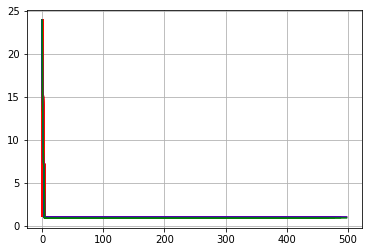

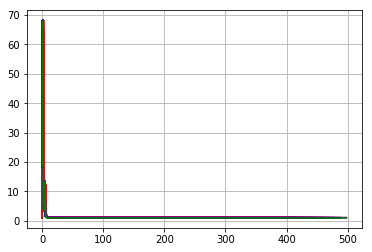

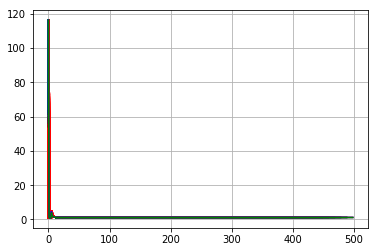

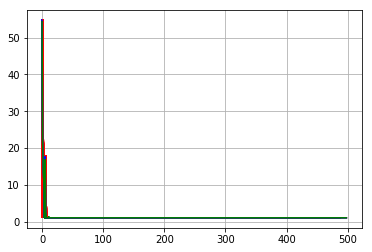

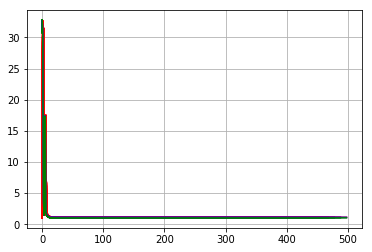

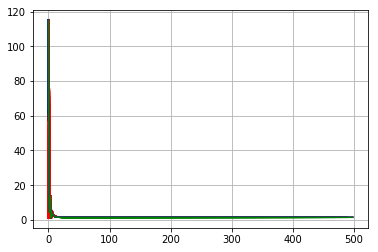

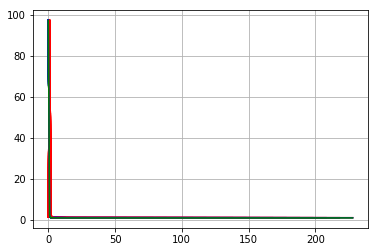

In [7]:
for s in sigma_list:
    #net.load_state_dict(torch.load(HOME_DIR+'split_data/torch_params_before'))

    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=lr, alpha=p)
    sheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    net, er_list, val_er_list, test_er_list = train_model(net, name=RES_DIR+name+str(s)+'errs.png',
                dataloaders=dataloaders, dataset_sizes=dataset_sizes,
                criterion=criterion, optimizer=optimizer, scheduler=sheduler,
                            num_epochs=num_epoch, sigma=s, noise_in=noise_in, noise_grad=noise_grad)

    errs_list['param'].append(s)
    errs_list['train'].append(er_list[-1])
    errs_list['val'].append(val_er_list[-1])
    errs_list['test'].append(test_er_list[-1])

    print('train: {}\nvalid: {}\ntest: {}'.format(er_list[-1], val_er_list[-1], test_er_list[-1]))

In [ ]:
plt.grid(True)
plt.plot(er_list, color='r')
plt.plot(val_er_list, color='b')
plt.plot(test_er_list, color='g')

In [ ]:
df = pd.DataFrame(errs_list)
df.to_csv(RES_DIR+'4_16_a2_err_lists.csv', index=False)

In [ ]:
df

In [ ]:
fig = plt.figure(figsize=(16, 10),)
plt.plot(df['param'], df['train'], color='b')
plt.plot(df['param'], df['test'], color='g')
plt.xlabel('Sigma', fontsize='xx-large')
plt.ylabel('Error', fontsize='xx-large')
plt.title('Noise input', fontsize='xx-large')
plt.legend(loc=0, fontsize='xx-large')
#plt.show()
plt.savefig('noise_input.png')